# Séparation de sources audio

*Lorenzo Brucato - Mohamed Amir Belkacem*

In [79]:
import sounddevice as sd 
from Datasets.Audiodata import *

___
### 1. Chargement des données et visualisation

*Chargement du dataset :*

In [2]:
dataset = Audiodataset(set='train_small')
print(len(dataset))

50


*Forme d'onde :*

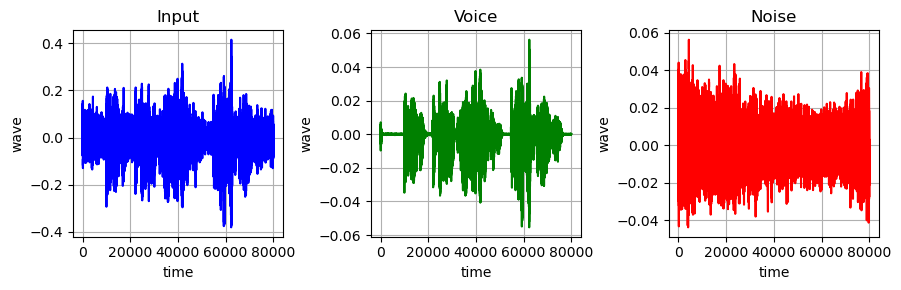

In [3]:
dataset.take_wave()
dataset.plot(0)

*Forme temps/fréquence :*

c:\Users\User\anaconda3\Lib\site-packages\torch\functional.py:704: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window can are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\SpectralOps.cpp:842.)
  return _VF.stft(  # type: ignore[attr-defined]


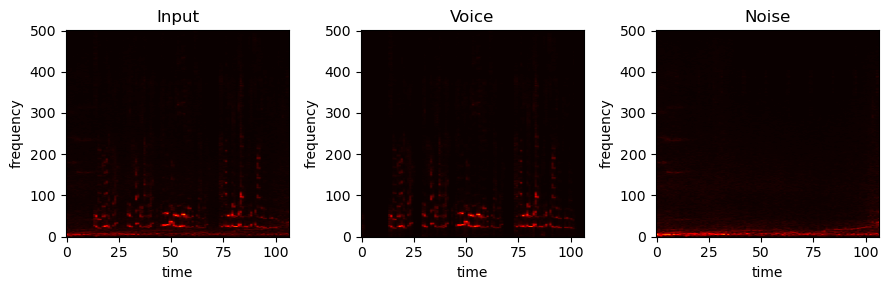

In [4]:
dataset.take_spectrogram()
dataset.plot(0)
plt.savefig('Figs/sp.png')

*Reconstruction du son depuis la représentation temps/fréquence :*

In [8]:
idx = 0
sr = 8000

dataset = Audiodataset('test', padding=True)
dataset.return_only_voice()
dataset.take_spectrogram()
X, VoiceSP = dataset[idx]

reconstruct = dataset.reconstruct(VoiceSP, idx, reference='voice')
sd.play(reconstruct.squeeze().numpy(), sr)
sd.wait()

___
### 2. WaveUNet

On se concentre dans cette partie sur l'implémentation d'un modèle génératif basé directement sur la forme d'onde sans passer sur la représentation temps/fréquence de la magnitude du signal.
On implémente le modèle dans des conditions similaires à celles décrites par *Stoller et al. (2018) https://arxiv.org/pdf/1806.03185*

L'architecture est un UNet sur la forme d'onde (structure encodeur/decodeur), composé de 12 layers d'encoding vers un espace de dimension réduit et 12 layers de upsampling pour retrouver le signal original masqué sur les composantes de bruit et de voix. Chaque étape de upsampling est contextualisé par une copie de l'état de downsampling à la même étape. Contrairement à un UNet classique, les auteurs proposent deux différences sur les méthodes de downsampling et de upsampling : 
- Les encodeurs réduisent la taille du signal d'entrée par décimation en supprimant de moitié les valeurs retenues de l'étape précédente
- les décodeurs réalisent un upsampling par interpolation linéaire au lieu de convolutions transposées, afin d'obtenir un meilleur lissage du signal et limiter l'apparition d'artefacts

Dans notre cas on décide de rééchantilloner le signal avec 65536 points au total sur les dix secondes d'audio (downsample avec taille en puissance de 2 pour simplifier le calcul des dimensions de convolution)

In [47]:
from Models.WaveUNet import *

N_POINTS = 65536

*Taille du modèle estimé (en nombre de paramètres) : ~ 10M*

In [84]:
model = WaveUNet()
print(np.sum([p.numel() for p in model.parameters()]))

10263028


*Chargement des données pour WaveUNet :*

In [48]:
train_dataset = Audiodataset('train', resample_n_points=N_POINTS, getitem='concatVN')
train_dataset.take_wave()

test_dataset = Audiodataset('test', resample_n_points=N_POINTS, getitem='concatVN')
test_dataset.take_wave()

*Entrainement :*

On utilise un batch size de 16 seulement (haute demande en ressources mémoires durant les étapes de downsampling) et un learning rate initial de 0.0001 pour l'optimiseur Adam comme décris dans l'article pour le modèle baseline :

In [49]:
# ==== Entrainement +20 epochs ====
# model, losses = WaveUNet.trainModel(train_dataset, n_epochs=20, batch_size=16, learning_rate=0.0001, valid_dataset=test_dataset)

*Evolution de la loss (MSE error) :*

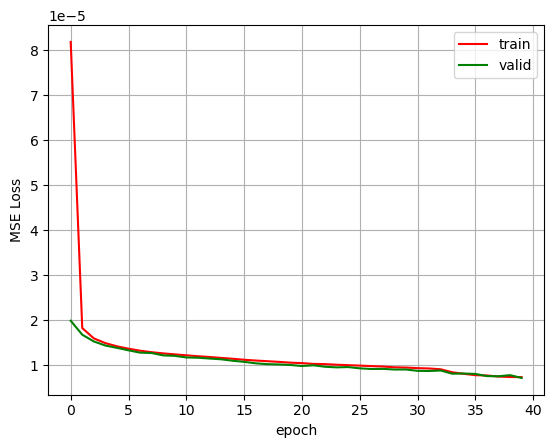

In [50]:
scores_WaveUNet = pd.read_csv('Scores/WaveUNet/WaveUNetMSE.csv')
train_error = scores_WaveUNet['train']
valid_error = scores_WaveUNet['valid']
plt.plot(train_error, color='red', label='train')
plt.plot(valid_error, color='green', label='valid')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE Loss')
plt.savefig('Figs/WaveUNetLoss.png')

**Ecoute sur une donnée de test :**

Visualisation et écoute de la performance du modèle génératif :

In [65]:
idx = 2

In [66]:
X, Y = test_dataset[idx]
model = WaveUNet()
model.load_state_dict(torch.load('Paths/WaveUNet/model_40.pth'))
output = model(X.unsqueeze(0))

C:\Users\User\AppData\Local\Temp\ipykernel_7516\333822859.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Paths/WaveUNet/model_40.pth')

*Comparaison Voix originale/Voix générée :*

C:\Users\User\AppData\Local\Temp\ipykernel_7516\4088492110.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
C:\Users\User\AppData\Local\Temp\ipykernel_7516\4088492110.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


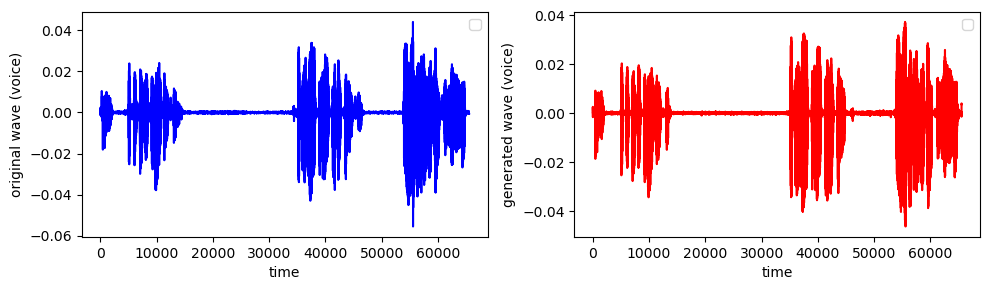

In [67]:
Vtrue = Y[0,:].squeeze().detach().numpy()
Vpred = output[:,0,:].squeeze().detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(Vtrue, color='blue')
axs[0].legend()
axs[0].set_xlabel('time')
axs[0].set_ylabel('original wave (voice)')

axs[1].plot(Vpred, color='red')
axs[1].legend()
axs[1].set_xlabel('time')
axs[1].set_ylabel('generated wave (voice)')

plt.tight_layout()
plt.savefig('Figs/WaveUNetVoiceEx.png')

*Comparaison Bruit original/Bruit généré :*

C:\Users\User\AppData\Local\Temp\ipykernel_7516\2963105354.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
C:\Users\User\AppData\Local\Temp\ipykernel_7516\2963105354.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


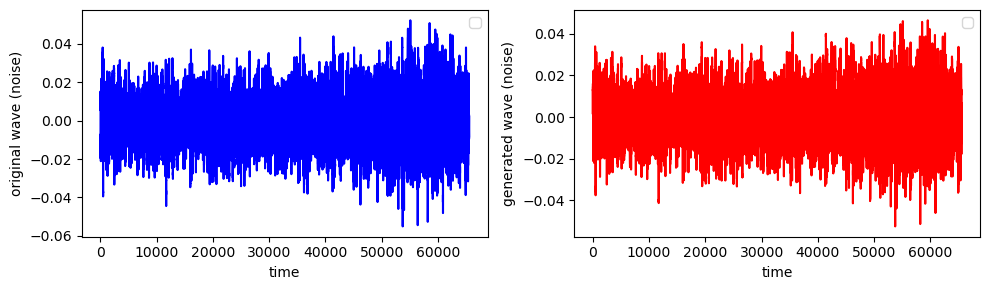

In [81]:
Ntrue = Y[1,:].squeeze().detach().numpy()
Npred = output[:,1,:].squeeze().detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(Ntrue, color='blue')
axs[0].legend()
axs[0].set_xlabel('time')
axs[0].set_ylabel('original wave (noise)')

axs[1].plot(Npred, color='red')
axs[1].legend()
axs[1].set_xlabel('time')
axs[1].set_ylabel('generated wave (noise)')

plt.tight_layout()
plt.savefig('Figs/WaveUNetNoiseEx.png')

*Ecoute du son original (bruité)/voix originale/voix générée/bruit original/bruit généré :*

In [80]:
# son original
sd.play(X.squeeze().detach().numpy(), N_POINTS/10)
sd.wait()

In [69]:
# voix originale
sd.play(Vtrue, N_POINTS/10)
sd.wait()

In [72]:
# voix générée (extraite du son original)
sd.play(Vpred, N_POINTS/10)
sd.wait()

In [82]:
# bruit original
sd.play(Ntrue, N_POINTS/10)
sd.wait()

In [83]:
# bruit généré (extrait du son original)
sd.play(Npred, N_POINTS/10)
sd.wait()